**Проект: Разработка модели предсказания температуры плавки металла**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

Нам предстоит построить модель, которая поможет оптимизировать производственные расходы, будем предсказывать температуру стали.


**План работы над проектом**
1. Загрузка данных. Рассмотрение полноты данных содержащихся в датасетах.
2. Исследование распределения величин и наличие выбросов в данных, которые могу оказать влияние на итоговые результаты. 
3. Замена пропущенных значений в таблицах wire и bulk нулями. Замена экстремально высокого значения в таблице arc(реактивная модность) средним значением по партии. Суммирование значений мощностей и выведение среднего значения по партии. Удаление пропущенных значений из таблицы temp, удаление партий товара имеющих 1 замер тепературы, удаление партий в которых значение температуры не превышало 1500 градусов. 
4. Объединение данных из датасетов в один датасет для дальнейшего формирования признаков и целевых значений для моделей машинного обучения.
5. Обучение моделей случайного леса (с автоматическим подбором гиперпараметров GridSearchCV), линейной регрессии, на полученных признаках и целевых значениях.
6. Сравнение метрик MAE полученных моделей между собой, выбор модели и аппробация ее на тестовых данных. Сравнение ее метрики MAE c MAE случайного регрессора DummyRegressor.
7. Подготовка выводов о пригодности модели для предсказаний величины температуры плавления стали с указанием гиперпараметров и этапов переработки данных.

### Исследование данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
display('Образцы датасетов')
display('Электроды', data_arc.head(5))
display('Cыпучие материалы', data_bulk.head(5))
display('Cыпучие материалы (время)',data_bulk_time.head(5))
display('Газ', data_gas.head(5))
display('Температура', data_temp.head(5))
display('Проволочные материалы', data_wire.head(5))
display('Проволочные материалы (время)',data_wire_time.head(5))

'Образцы датасетов'

'Электроды'

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


'Cыпучие материалы'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


'Cыпучие материалы (время)'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


'Газ'

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


'Температура'

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


'Проволочные материалы'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Проволочные материалы (время)'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
display('Статистическая информация о датасетах')
display('Электроды', data_arc.describe())
display('Cыпучие материалы', data_bulk.describe())
display('Газ', data_gas.describe())
display('Температура', data_temp.describe())
display('Проволочные материалы', data_wire.describe())

'Статистическая информация о датасетах'

'Электроды'

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


'Cыпучие материалы'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


'Газ'

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


'Температура'

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


'Проволочные материалы'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [5]:
display('Информация о пропусках')
display('Электроды', data_arc.isna().mean())
display('Cыпучие материалы', data_bulk.isna().mean())
display('Газ', data_gas.isna().mean())
display('Температура', data_temp.isna().mean())
display('Проволочные материалы', data_wire.isna().mean())

'Информация о пропусках'

'Электроды'

key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64

'Cыпучие материалы'

key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

'Газ'

key      0.0
Газ 1    0.0
dtype: float64

'Температура'

key             0.000000
Время замера    0.000000
Температура     0.182373
dtype: float64

'Проволочные материалы'

key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

In [6]:
display('Информация о типах данных в датасетах')
display('Электроды', data_arc.info())
display('Cыпучие материалы', data_bulk.info())
display('Газ', data_gas.isna().info())
display('Температура', data_temp.info())
display('Проволочные материалы', data_wire.info())

'Информация о типах данных в датасетах'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


'Электроды'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


'Cыпучие материалы'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   key     3239 non-null   bool 
 1   Газ 1   3239 non-null   bool 
dtypes: bool(2)
memory usage: 6.5 KB


'Газ'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


'Температура'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


'Проволочные материалы'

None

Обнаружены пропуски во всех таблицах, кроме таблицы "Электроды" и "Газ"

array([[<AxesSubplot:title={'center':'Начало нагрева дугой'}>,
        <AxesSubplot:title={'center':'Конец нагрева дугой'}>],
       [<AxesSubplot:title={'center':'Активная мощность'}>,
        <AxesSubplot:title={'center':'Реактивная мощность'}>]],
      dtype=object)

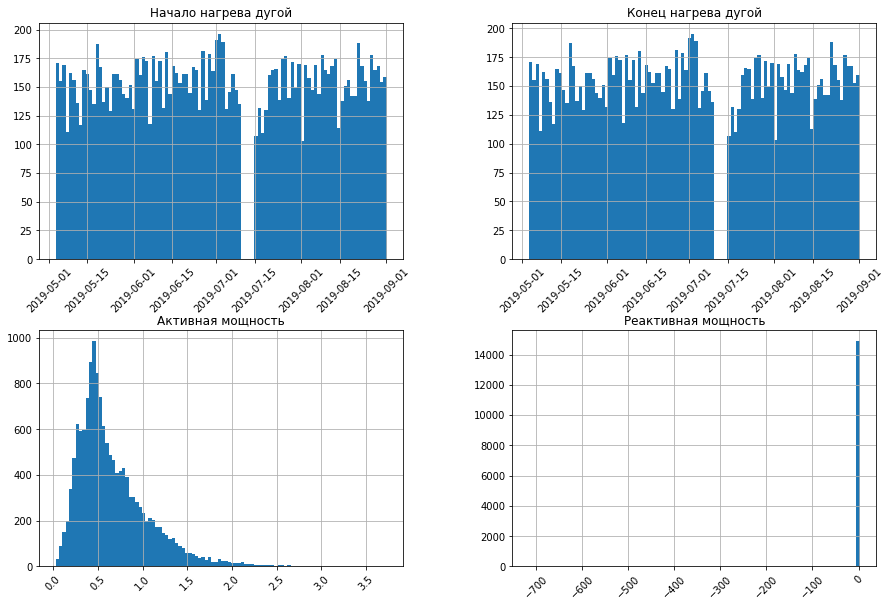

In [7]:
#Приведем столбцы с временем и датой к формату "Datetime".
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc.hist(column = ['Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность'], 
              bins=100, figsize = (15, 10), xrot=45)

<AxesSubplot:>

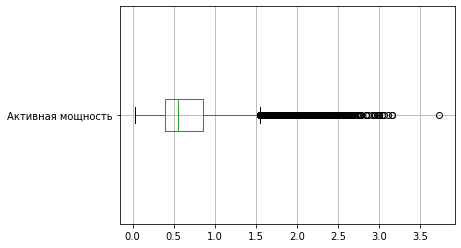

In [8]:
data_arc.boxplot(column=['Активная мощность'], vert=False)

<AxesSubplot:>

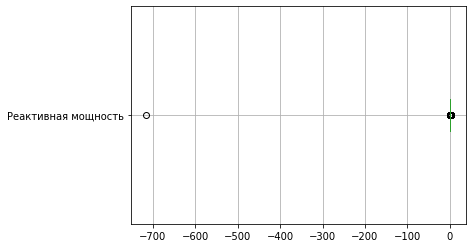

In [9]:
data_arc.boxplot(column=['Реактивная мощность'], vert=False)

In [10]:
key_neg = data_arc[data_arc['Реактивная мощность']<0]['key']
data_arc.query('key in @key_neg')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Значения активной мощности и имеет приблизительно нормальное распределение с незначительным правым хвостом (среднее больше медианы). Распределение реактивной мощности оценить невозможно по причине наличия в столбце большого (по сравнению с остальными) отрицательного значения. Учитывая особенности производственного процесса одной партии товара соответсвует несколько операций нагрева.

array([[<AxesSubplot:title={'center':'Bulk 1'}>,
        <AxesSubplot:title={'center':'Bulk 2'}>,
        <AxesSubplot:title={'center':'Bulk 3'}>,
        <AxesSubplot:title={'center':'Bulk 4'}>],
       [<AxesSubplot:title={'center':'Bulk 5'}>,
        <AxesSubplot:title={'center':'Bulk 6'}>,
        <AxesSubplot:title={'center':'Bulk 7'}>,
        <AxesSubplot:title={'center':'Bulk 8'}>],
       [<AxesSubplot:title={'center':'Bulk 9'}>,
        <AxesSubplot:title={'center':'Bulk 10'}>,
        <AxesSubplot:title={'center':'Bulk 11'}>,
        <AxesSubplot:title={'center':'Bulk 12'}>],
       [<AxesSubplot:title={'center':'Bulk 13'}>,
        <AxesSubplot:title={'center':'Bulk 14'}>,
        <AxesSubplot:title={'center':'Bulk 15'}>, <AxesSubplot:>]],
      dtype=object)

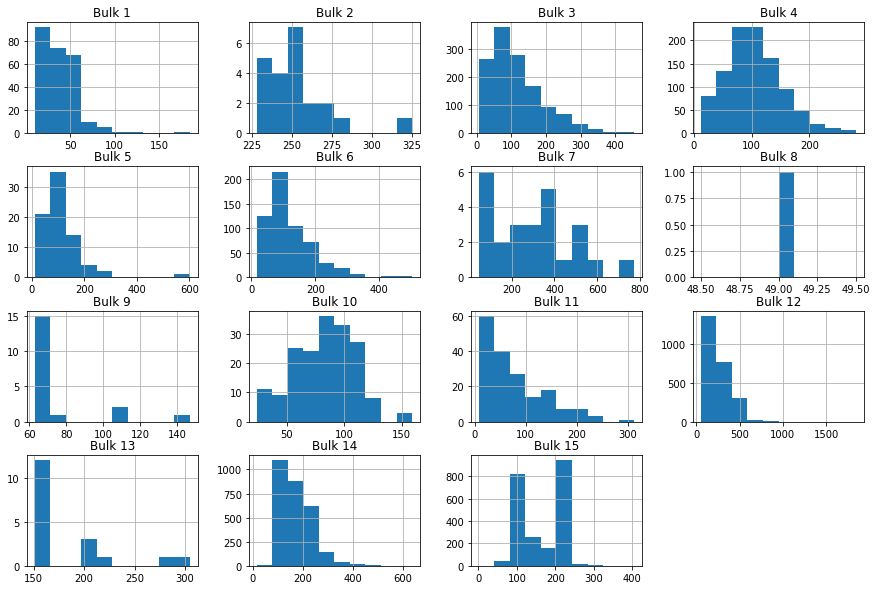

In [11]:
data_bulk.hist(column=['Bulk 1','Bulk 2','Bulk 3','Bulk 4','Bulk 5','Bulk 6','Bulk 7',
                    'Bulk 8','Bulk 9','Bulk 10','Bulk 11','Bulk 12','Bulk 13','Bulk 14','Bulk 15'],
               bins=10, figsize=(15,10))

<AxesSubplot:>

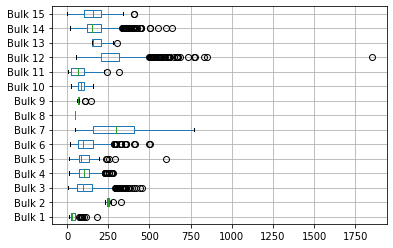

In [12]:
data_bulk.boxplot(column=['Bulk 1','Bulk 2','Bulk 3','Bulk 4','Bulk 5','Bulk 6','Bulk 7',
                    'Bulk 8','Bulk 9','Bulk 10','Bulk 11','Bulk 12','Bulk 13','Bulk 14','Bulk 15'], vert=False)

In [13]:
data_bulk.rename(columns={'Bulk 1':'bulk_1','Bulk 2':'bulk_2','Bulk 3':'bulk_3','Bulk 4':'bulk_4',
                          'Bulk 5':'bulk_5','Bulk 6':'bulk_6','Bulk 7':'bulk_7','Bulk 8':'bulk_8',
                          'Bulk 9':'bulk_9','Bulk 10':'bulk_10','Bulk 11':'bulk_11','Bulk 12':'bulk_12',
                          'Bulk 13':'bulk_13','Bulk 14':'bulk_14','Bulk 15':'bulk_15'}, inplace=True
                )

На графиках подачи сыпучих материалов видно, что некоторые материалы подаются редко (2, 7, 8, 9, 13) некоторые часто (12, 14, 15). Пропуски в данной таблице означают что материал в плавку не подавался. Выбросы есть в данных практически о всех материалах.

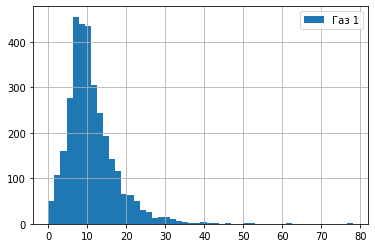

In [14]:
data_gas['Газ 1'].hist(bins=50, legend = 'Суммарная подача газа')
data_gas.rename(columns = {'key':'key','Газ 1':'gas_cons'}, inplace=True)

<AxesSubplot:>

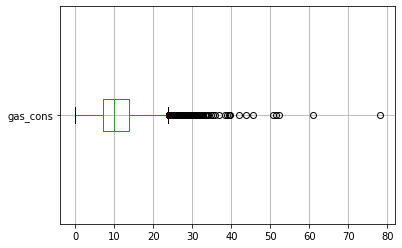

In [15]:
data_gas.boxplot(column=['gas_cons'], vert=False)

график величины Поданный газ имеет вид близкий к графику нормального распределения с длинным правым хвостом (среднее значительно больше медианы)

array([[<AxesSubplot:title={'center':'Время замера'}>,
        <AxesSubplot:title={'center':'Температура'}>]], dtype=object)

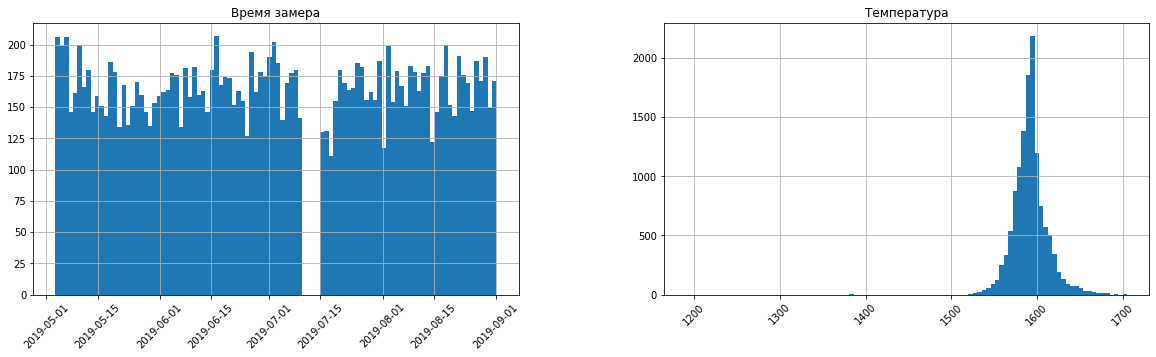

In [16]:
data_temp ['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp.hist(column=['Время замера', 'Температура'], bins=100, figsize=(20,5), xrot=45)

<AxesSubplot:>

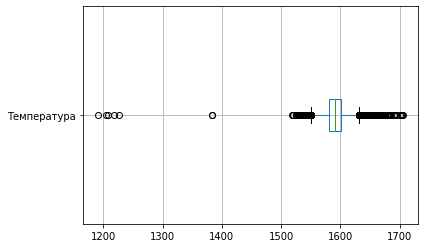

In [17]:
data_temp.boxplot(column=['Температура'], vert=False)

In [18]:
data_temp[data_temp.isna().any(axis=1)]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


график величины температура имеет вид близкий к графику нормального распределения с выбросами как вправо так и влево. По причине того что замер не один, одной партии товара соответствует несколько замеров температуры. Партии начиная с 2500 имеют пропуски в значениях температуры при наличии времени замера.

array([[<AxesSubplot:title={'center':'Wire 1'}>,
        <AxesSubplot:title={'center':'Wire 2'}>,
        <AxesSubplot:title={'center':'Wire 3'}>],
       [<AxesSubplot:title={'center':'Wire 4'}>,
        <AxesSubplot:title={'center':'Wire 5'}>,
        <AxesSubplot:title={'center':'Wire 6'}>],
       [<AxesSubplot:title={'center':'Wire 7'}>,
        <AxesSubplot:title={'center':'Wire 8'}>,
        <AxesSubplot:title={'center':'Wire 9'}>]], dtype=object)

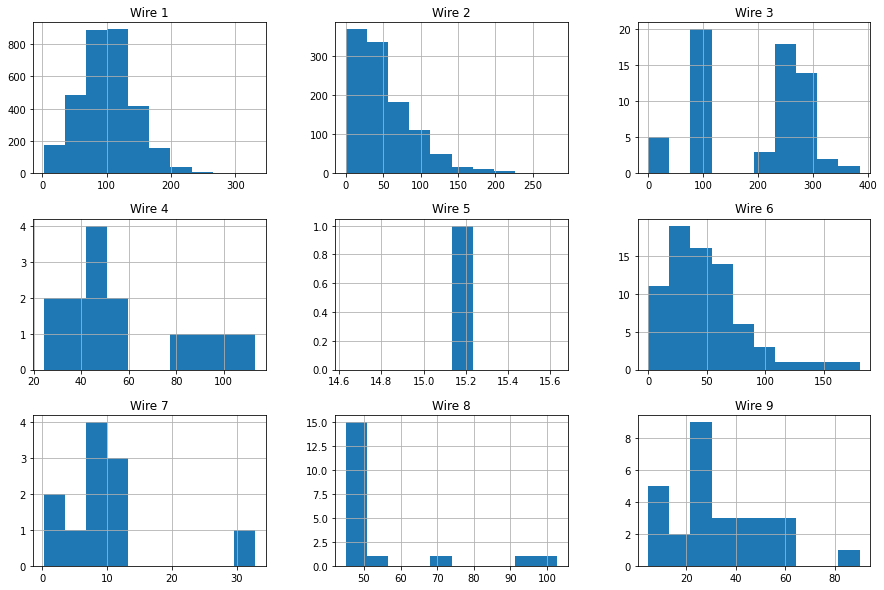

In [19]:
data_wire.hist(column = ['Wire 1', 'Wire 2', 'Wire 3','Wire 4',
                                    'Wire 5','Wire 6','Wire 7','Wire 8','Wire 9'], 
                     bins=10, figsize=(15,10),)

<AxesSubplot:>

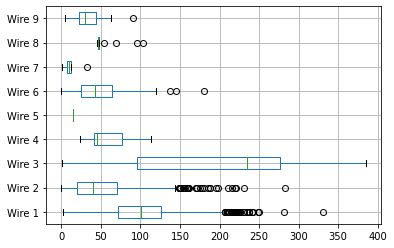

In [20]:
data_wire.boxplot(column=['Wire 1', 'Wire 2', 'Wire 3','Wire 4',
                                    'Wire 5','Wire 6','Wire 7','Wire 8','Wire 9'], vert=False)

In [21]:
data_wire.rename(columns={'Wire 1':'wire_1', 'Wire 2':'wire_2', 'Wire 3':'wire_3','Wire 4':'wire_4',
                'Wire 5':'wire_5','Wire 6':'wire_6','Wire 7':'wire_7','Wire 8':'wire_8','Wire 9':'wire_9'}, inplace=True
                )

Некоторые проволочные материалы подаются в производственный процесс редко (4,5,7) некоторые часто (1,2). Пропуски в данной таблице означают, что материал в при плавке не использовался. Имеются выбросы в данных по материалам (1,2).

**Выводы по исследовательскому анализу:**<br>
1. Загружены датасеты (затраченная мощность, объем сыпучих и проволочных материалов, затраченный объем газа, замеры температуры на разных этапах плавления) о характиристиках производственного процесса литья стали.
2. Данные имеют пропуски кроме датасетов затраченная мощность и затраченный газ. В датасетах объем сыпучих и проволочных материалов означает что тот или иной материал не добавлялся в производство. В датасете замеры температуры отсутствуют значения температуры в партиях начиная с 2500.
3. Построенны графики распределения каждого из параметров производственного процесса.

### Переработка данных

In [22]:
# заполняем выброс в показателе реактивная мощность
data_arc.loc[data_arc['Реактивная мощность']<0, 'Реактивная мощность']=np.nan
data_arc['Реактивная мощность'].fillna(data_arc.groupby('key')['Реактивная мощность'].transform('mean'), inplace=True)

In [23]:
#расчитываем показатель работы для показателей мощности и времени
data_arc['time'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой'])/pd.Timedelta(1, unit='m')
data_arc['work'] = (data_arc['Реактивная мощность']+data_arc['Активная мощность'])*data_arc['time']

In [24]:
#рассчитываем агрегированный показатели работы и количества операций нагрева
data_arc['total_work'] = data_arc.groupby('key')['work'].transform('sum')
data_arc['qty_iter'] = data_arc.groupby('key')['key'].transform('count')

In [25]:
# удаляем лишние строки и столбцы
data_arc.drop_duplicates(subset= 'key', inplace=True)

In [26]:
data_arc_fin = data_arc.drop(['Начало нагрева дугой','Конец нагрева дугой','Активная мощность','Реактивная мощность',
                              'time', 'work'], axis=1)

In [27]:
data_arc_fin

,key,total_work,qty_iter
0,1,33.261863,5
5,2,20.356786,4
9,3,12.075336,5
14,4,18.343321,4
18,5,27.707270,4
...,...,...,...
14850,3237,22.288798,5
14855,3238,13.019877,3
14858,3239,23.382365,8
14866,3240,17.098118,5


In [28]:
#заполняем пропущенные данные в таблицах bulk и wire
data_bulk.fillna(0, inplace=True)
data_wire.fillna(0, inplace=True)

In [29]:
#удаляем пропуски в таблице temp, рассичитваем количество замеров температуры
data_temp.dropna(inplace=True)

In [30]:
data_temp['count_key']=data_temp.groupby('key')['key'].transform('count')
data_temp['count_key']=data_temp['count_key'].replace(1, np.nan)
data_temp.dropna(inplace=True)

In [31]:
# определяем номера партий где температура нагревы была менее 1500 град и исключаем записи с этими ключами
key_low_temp = data_temp[data_temp['Температура']<1500]['key']
data_temp = data_temp.query('key not in @key_low_temp')

In [32]:
#формируем столбцы с начальной температурой партии и конечной температурой партии
data_temp['temp_start'] = data_temp.groupby('key')['Температура'].transform('first')
data_temp['temp_end'] = data_temp.groupby('key')['Температура'].transform('last')

In [33]:
# удаляем лишние строки и столбцы
data_temp.drop_duplicates(subset='key', inplace=True)

In [34]:
data_temp_fin = data_temp.drop(['Время замера', 'Температура', 'count_key'], axis=1)

In [35]:
data_temp_fin

,key,temp_start,temp_end
0,1,1571.0,1613.0
5,2,1581.0,1602.0
11,3,1596.0,1599.0
16,4,1601.0,1625.0
19,5,1576.0,1602.0
...,...,...,...
12250,2495,1570.0,1591.0
12253,2496,1554.0,1591.0
12257,2497,1571.0,1589.0
12259,2498,1591.0,1594.0


In [36]:
# объединяем датасеты
total_data = (data_temp_fin.merge(data_arc_fin, on='key', how='inner')
              .merge(data_bulk, on='key', how='inner').merge(data_wire, on='key', how='inner')
              .merge(data_gas, on='key', how='inner'))

In [37]:
total_data

,key,temp_start,temp_end,total_work,qty_iter,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_cons
0,1,1571.0,1613.0,33.261863,5,0.0,0.0,0.0,43.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,20.356786,4,0.0,0.0,0.0,73.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,12.075336,5,0.0,0.0,0.0,34.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,18.343321,4,0.0,0.0,0.0,81.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,27.707270,4,0.0,0.0,0.0,78.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,18.145664,4,0.0,0.0,21.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2321,2496,1554.0,1591.0,20.228502,6,0.0,0.0,0.0,63.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2322,2497,1571.0,1589.0,13.072876,3,0.0,0.0,0.0,85.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2323,2498,1591.0,1594.0,17.813904,5,0.0,0.0,90.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657


In [38]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2325 non-null   int64  
 1   temp_start  2325 non-null   float64
 2   temp_end    2325 non-null   float64
 3   total_work  2325 non-null   float64
 4   qty_iter    2325 non-null   int64  
 5   bulk_1      2325 non-null   float64
 6   bulk_2      2325 non-null   float64
 7   bulk_3      2325 non-null   float64
 8   bulk_4      2325 non-null   float64
 9   bulk_5      2325 non-null   float64
 10  bulk_6      2325 non-null   float64
 11  bulk_7      2325 non-null   float64
 12  bulk_8      2325 non-null   float64
 13  bulk_9      2325 non-null   float64
 14  bulk_10     2325 non-null   float64
 15  bulk_11     2325 non-null   float64
 16  bulk_12     2325 non-null   float64
 17  bulk_13     2325 non-null   float64
 18  bulk_14     2325 non-null   float64
 19  bulk_15     2325 non-null  

In [39]:
total_data.isna().mean()

key           0.0
temp_start    0.0
temp_end      0.0
total_work    0.0
qty_iter      0.0
bulk_1        0.0
bulk_2        0.0
bulk_3        0.0
bulk_4        0.0
bulk_5        0.0
bulk_6        0.0
bulk_7        0.0
bulk_8        0.0
bulk_9        0.0
bulk_10       0.0
bulk_11       0.0
bulk_12       0.0
bulk_13       0.0
bulk_14       0.0
bulk_15       0.0
wire_1        0.0
wire_2        0.0
wire_3        0.0
wire_4        0.0
wire_5        0.0
wire_6        0.0
wire_7        0.0
wire_8        0.0
wire_9        0.0
gas_cons      0.0
dtype: float64

<AxesSubplot:>

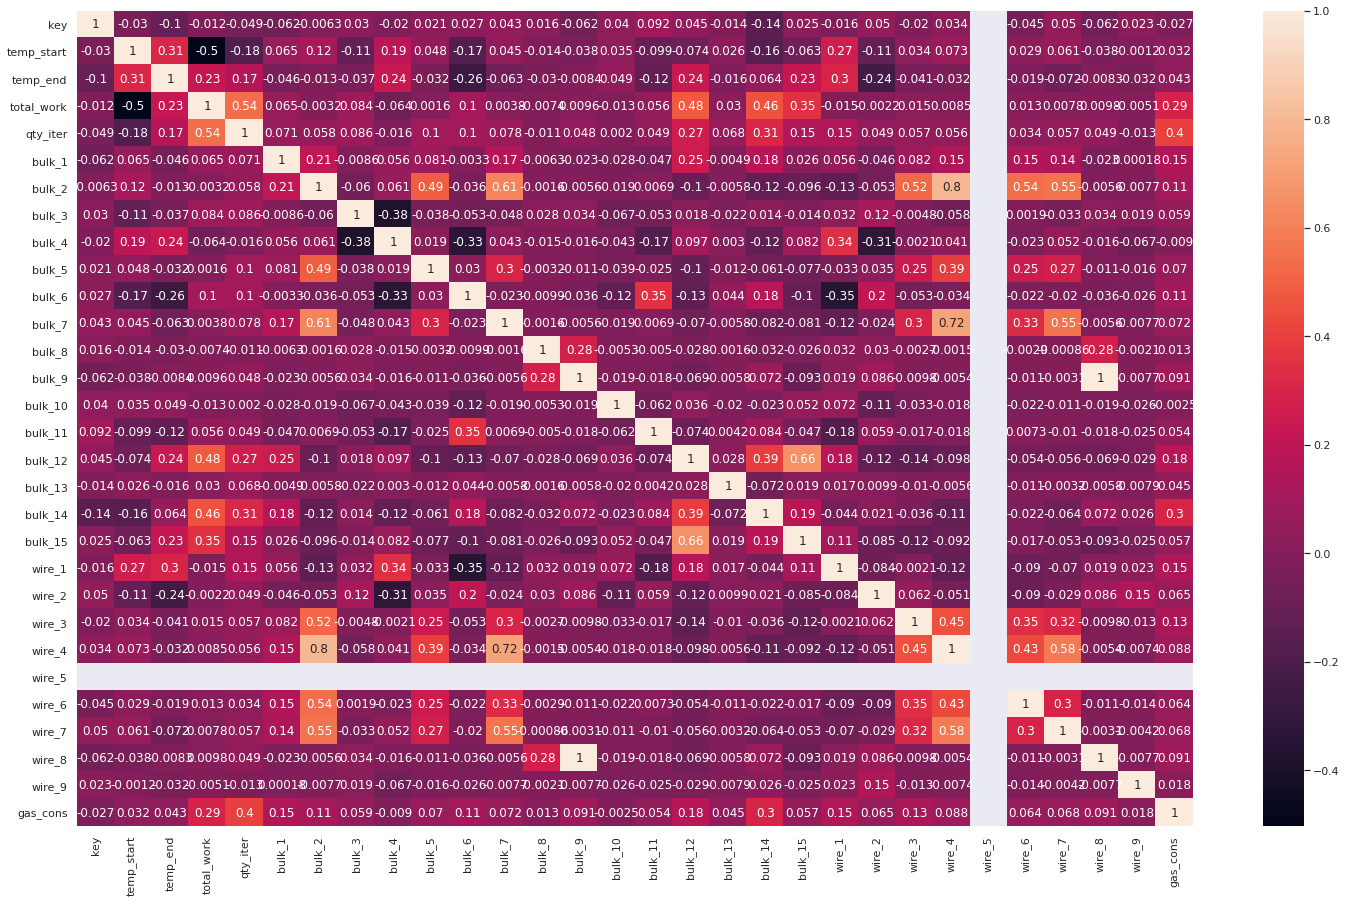

In [40]:
# построим корреляцию итоговых признаков
sns.set(rc = {'figure.figsize':(25,15)})
sns.heatmap(total_data.corr(method='spearman'), annot=True)

Целевой признак temp_end слабо положительно коррелирует с параметрами стартовой температуры, средней работой и количеством нагревов партии, а так же с количеством сыпучих материалов 12, 15 и проволочного материала 1. Параметр имеет слабую отрицательную корреляцию с сыпучими материалами 6, 11 и проволочным материалом 2. С остальными параметрами корреляция не значительна. Мультиколлениарности (большого количества парного совпадения корреляции разных признаков) в признаках не прослеживается. Далее построим графики параметров пополучившегося итогового датасета

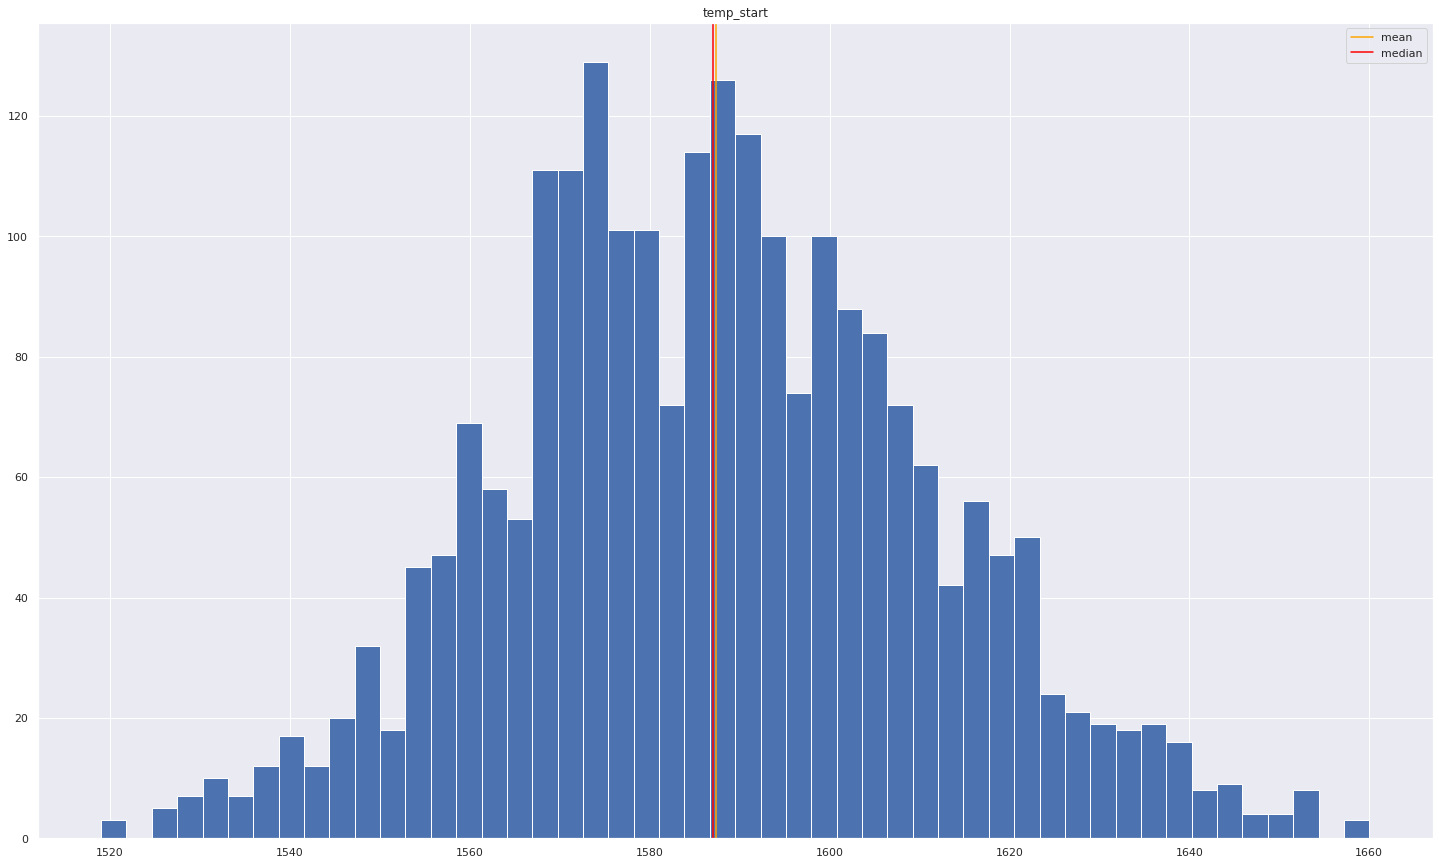

In [41]:
#гистограмма начальной температуры
total_data.hist(column = ['temp_start'], bins=50)
plt.axvline(total_data['temp_start'].mean(), color='orange', label='mean')
plt.axvline(total_data['temp_start'].median(), color='red', label='median')
plt.legend()

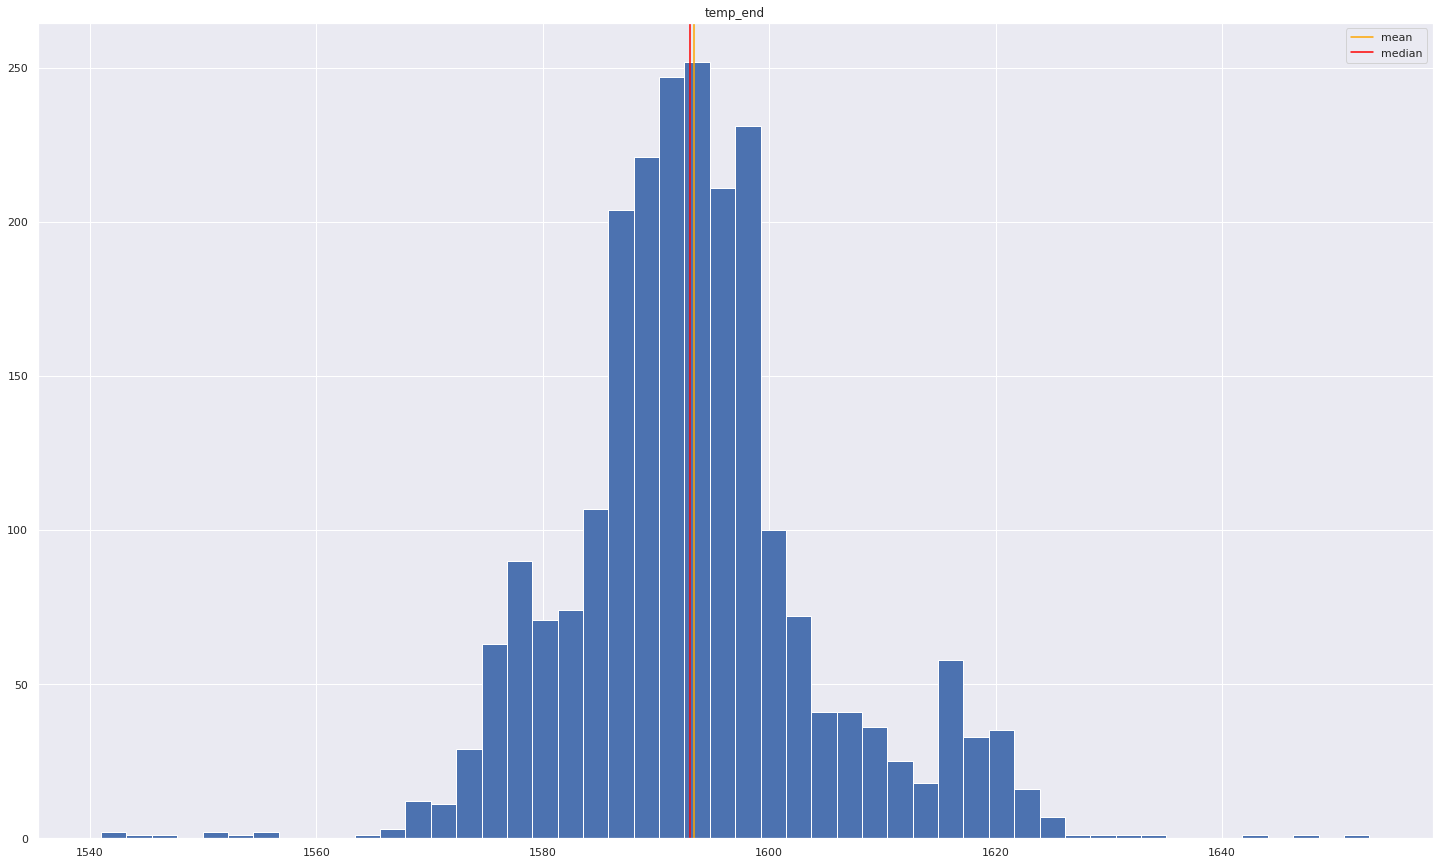

In [42]:
#гистограмма конечной температуры
total_data.hist(column = ['temp_end'], bins=50)
plt.axvline(total_data['temp_end'].mean(), color='orange', label='mean')
plt.axvline(total_data['temp_end'].median(), color='red', label='median')
plt.legend()

графики распределения температур имею форму близкую к нормальному распределению. График начальных температур характеризуется 2 большими пиками и скачкообразным краями. График конечных температур имеет заостренный пик и неровные подъем и спуск с локальными пиками.

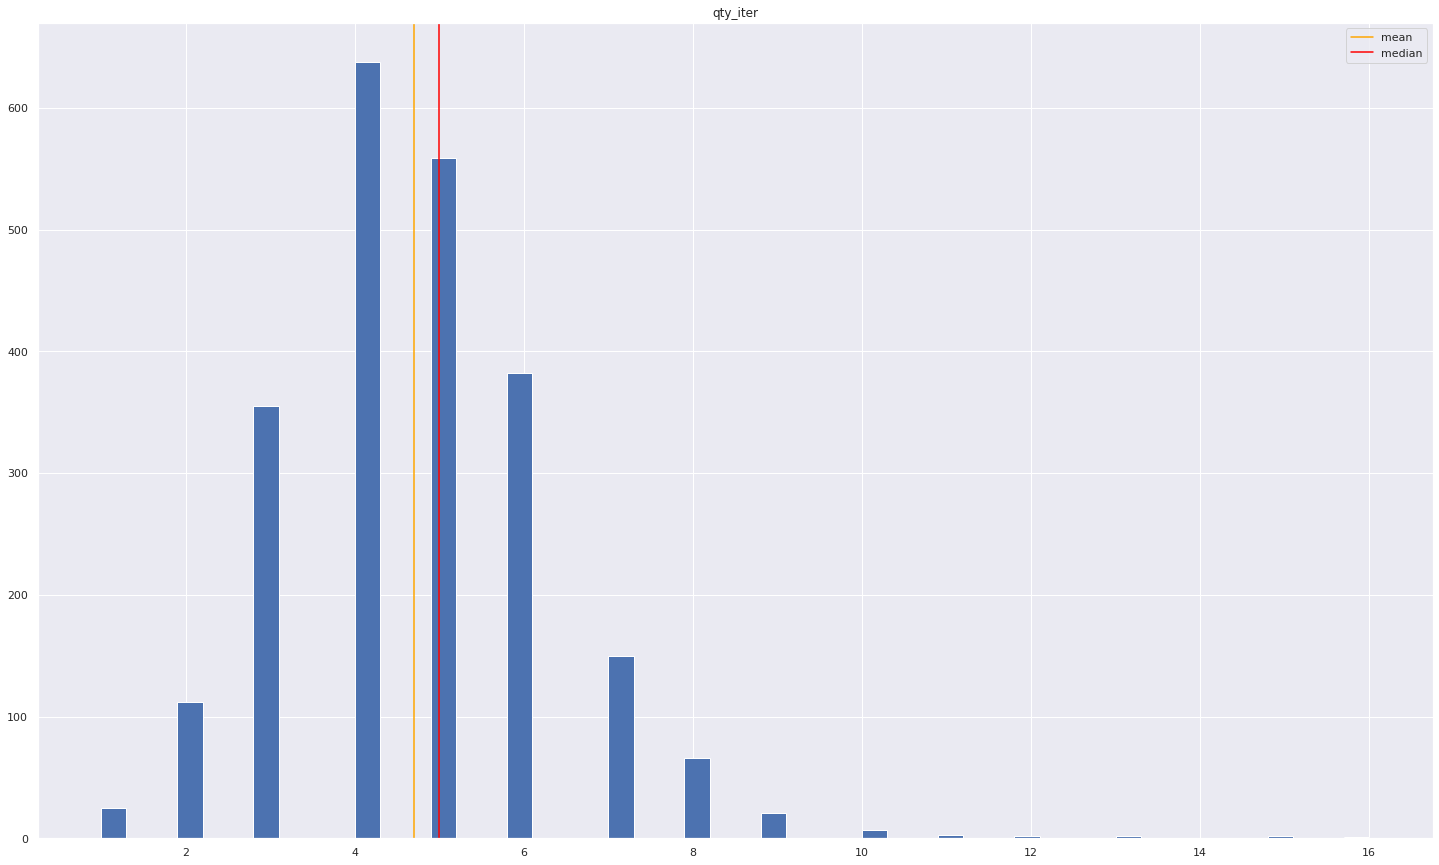

In [43]:
#гистограмма количества операций нагрева
total_data.hist(column = ['qty_iter'], bins=50)
plt.axvline(total_data['qty_iter'].mean(), color='orange', label='mean')
plt.axvline(total_data['qty_iter'].median(), color='red', label='median')
plt.legend()

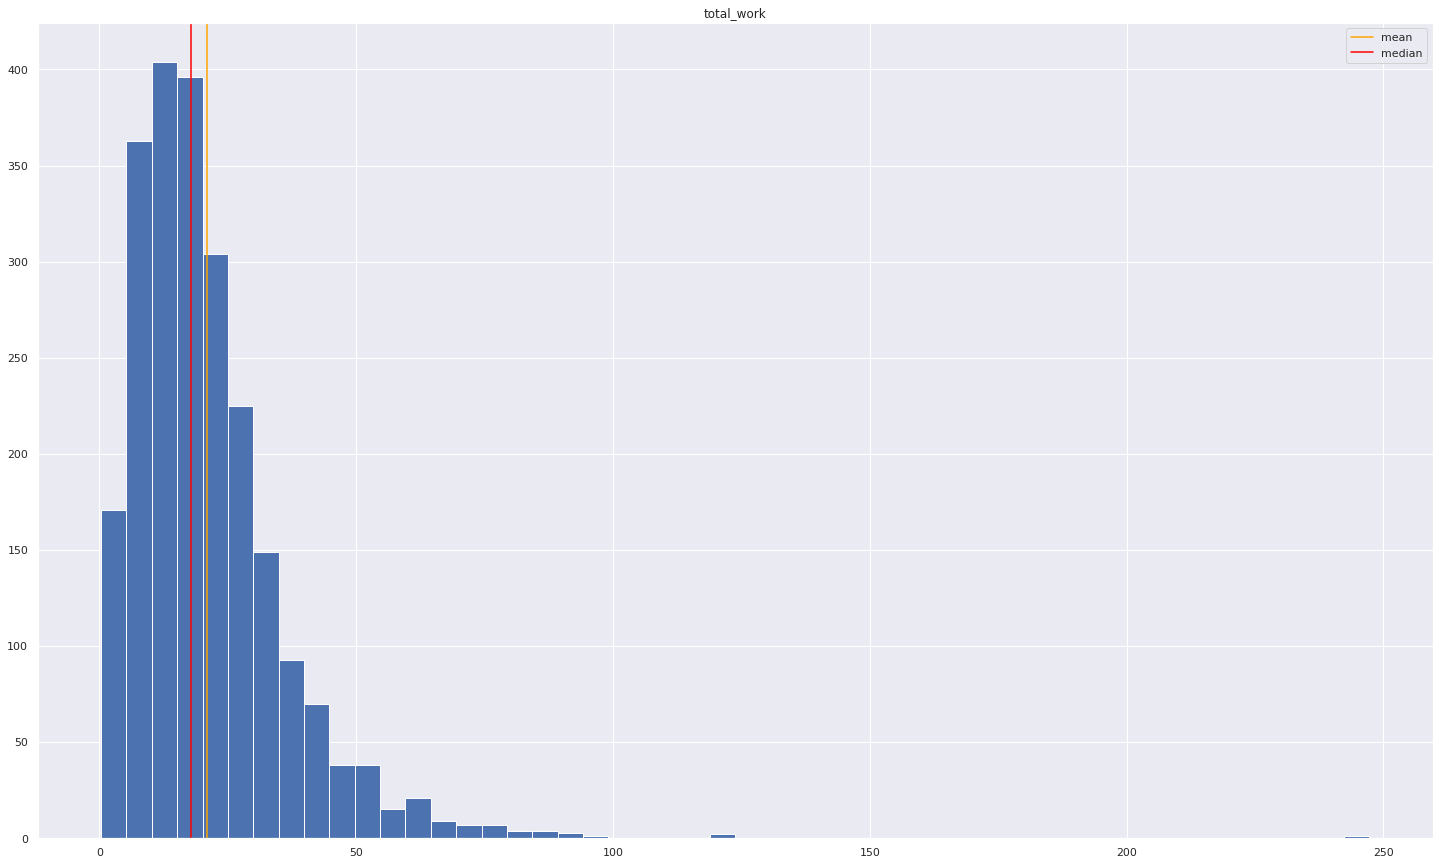

In [44]:
#гистограмма суммарной работы
total_data.hist(column = ['total_work'], bins=50)
plt.axvline(total_data['total_work'].mean(), color='orange', label='mean')
plt.axvline(total_data['total_work'].median(), color='red', label='median')
plt.legend()

график общей работы имеет крутой подъем слева и более плавный спуск слева. график количества операций нагрева имеет вид близкий к виду графика нормального распределения.

array([[<AxesSubplot:title={'center':'bulk_1'}>,
        <AxesSubplot:title={'center':'bulk_2'}>,
        <AxesSubplot:title={'center':'bulk_3'}>,
        <AxesSubplot:title={'center':'bulk_4'}>],
       [<AxesSubplot:title={'center':'bulk_5'}>,
        <AxesSubplot:title={'center':'bulk_6'}>,
        <AxesSubplot:title={'center':'bulk_7'}>,
        <AxesSubplot:title={'center':'bulk_8'}>],
       [<AxesSubplot:title={'center':'bulk_9'}>,
        <AxesSubplot:title={'center':'bulk_10'}>,
        <AxesSubplot:title={'center':'bulk_11'}>,
        <AxesSubplot:title={'center':'bulk_12'}>],
       [<AxesSubplot:title={'center':'bulk_13'}>,
        <AxesSubplot:title={'center':'bulk_14'}>,
        <AxesSubplot:title={'center':'bulk_15'}>, <AxesSubplot:>]],
      dtype=object)

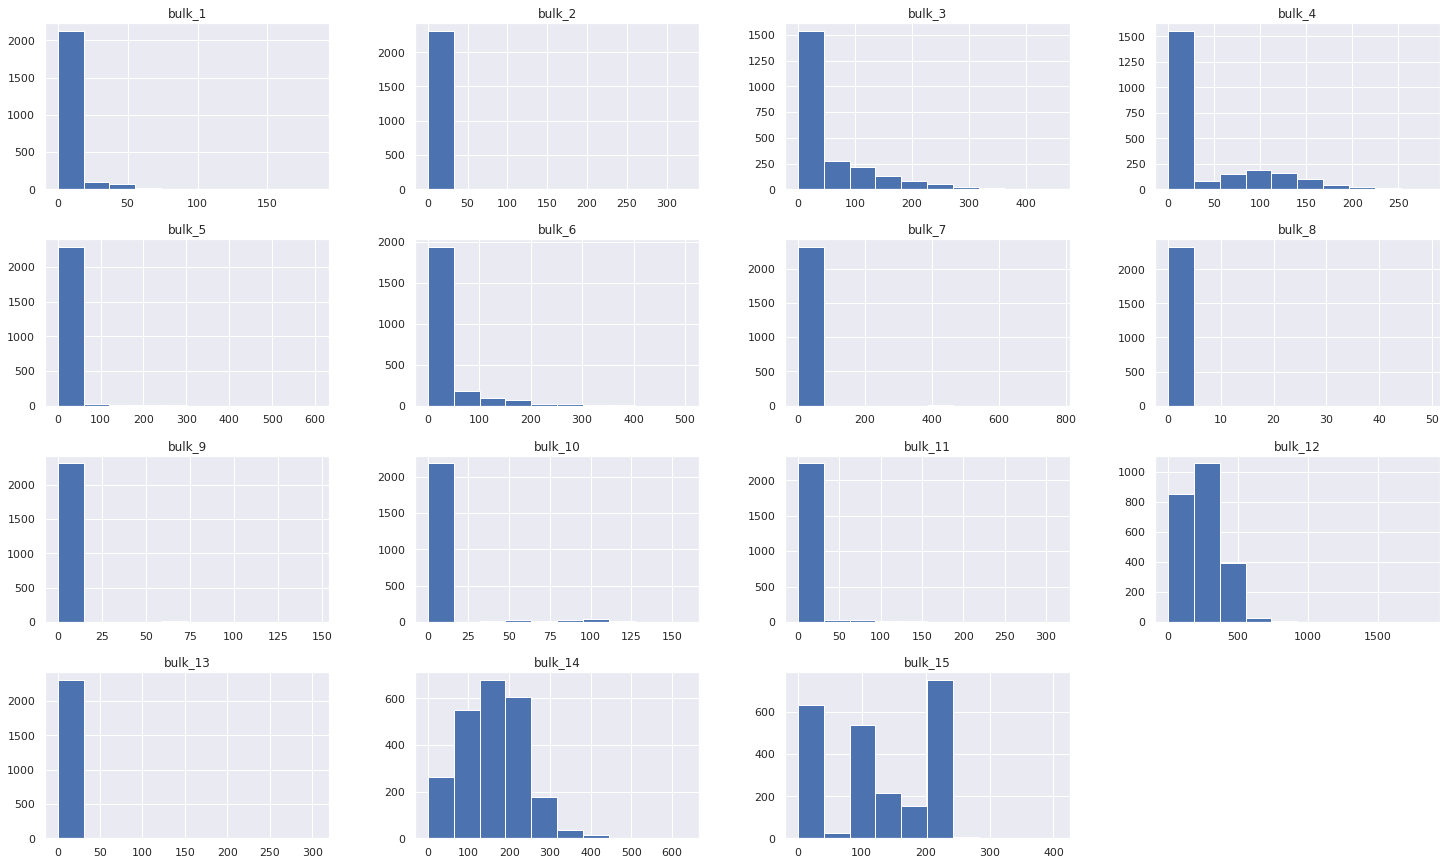

In [45]:
#гистограммы расхода сыпучих материалов
total_data.hist(column=['bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6',
                        'bulk_7','bulk_8','bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14',
                        'bulk_15'], bins=10)

array([[<AxesSubplot:title={'center':'wire_1'}>,
        <AxesSubplot:title={'center':'wire_2'}>,
        <AxesSubplot:title={'center':'wire_3'}>],
       [<AxesSubplot:title={'center':'wire_4'}>,
        <AxesSubplot:title={'center':'wire_5'}>,
        <AxesSubplot:title={'center':'wire_6'}>],
       [<AxesSubplot:title={'center':'wire_7'}>,
        <AxesSubplot:title={'center':'wire_8'}>,
        <AxesSubplot:title={'center':'wire_9'}>]], dtype=object)

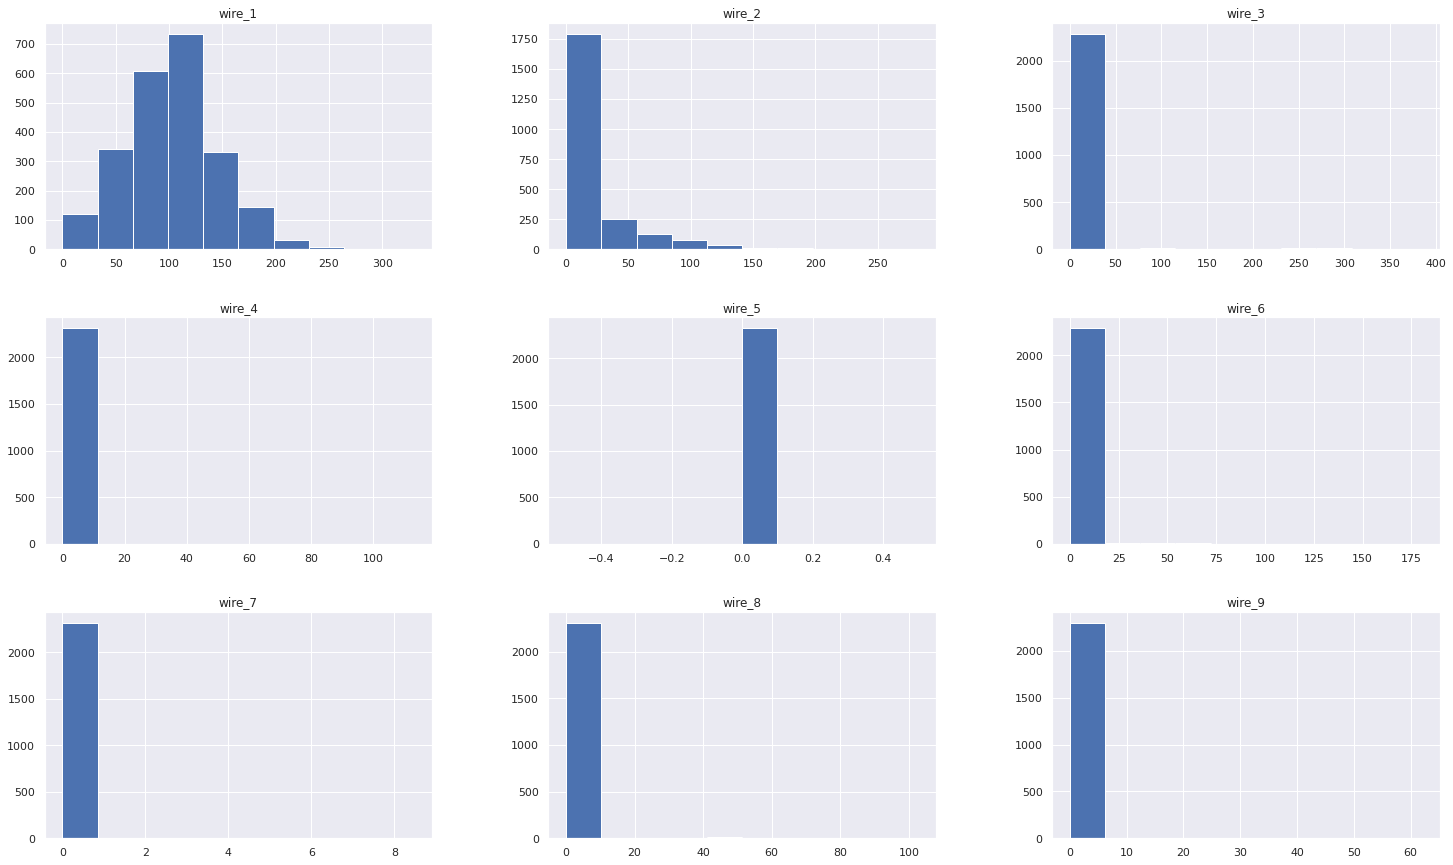

In [46]:
#гистограммы подачи проволочных материалов
total_data.hist(column=['wire_1','wire_2','wire_3','wire_4','wire_5','wire_6',
                        'wire_7','wire_8','wire_9'], bins=10)

графики распределения расхода сыпучих материалов имеют в основном схожую форму - один столбец около нулевого значения (кроме bulk_1, bulk_3, bulk_4, bulk_6, bulk_10, bulk_12, bulk_14, bulk_15, wire_1, wire_2) . На диаграммах размаха видно, что наименьшее количество данных содержат столбцы wire_5 и bulk_8 предлагается удалить их из признаков (на диаграмме корреляции данные признаки имеют незначительное влияние на целевой признак).

<AxesSubplot:>

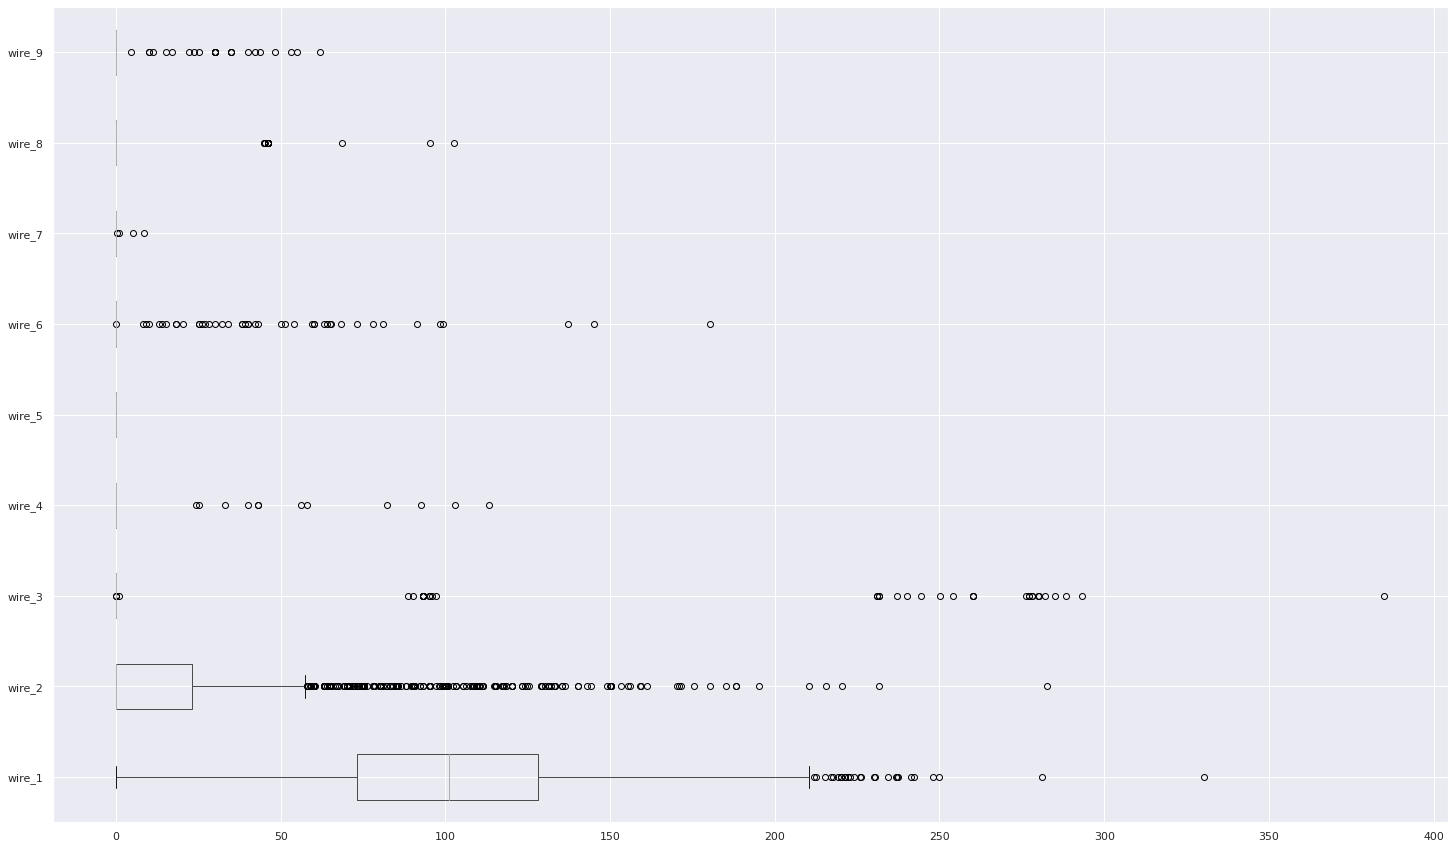

In [47]:
#диаграммы размаха подачи проволочных материалов
total_data.boxplot(column = ['wire_1','wire_2','wire_3','wire_4','wire_5','wire_6',
                             'wire_7','wire_8','wire_9'], vert=False
                  )

<AxesSubplot:>

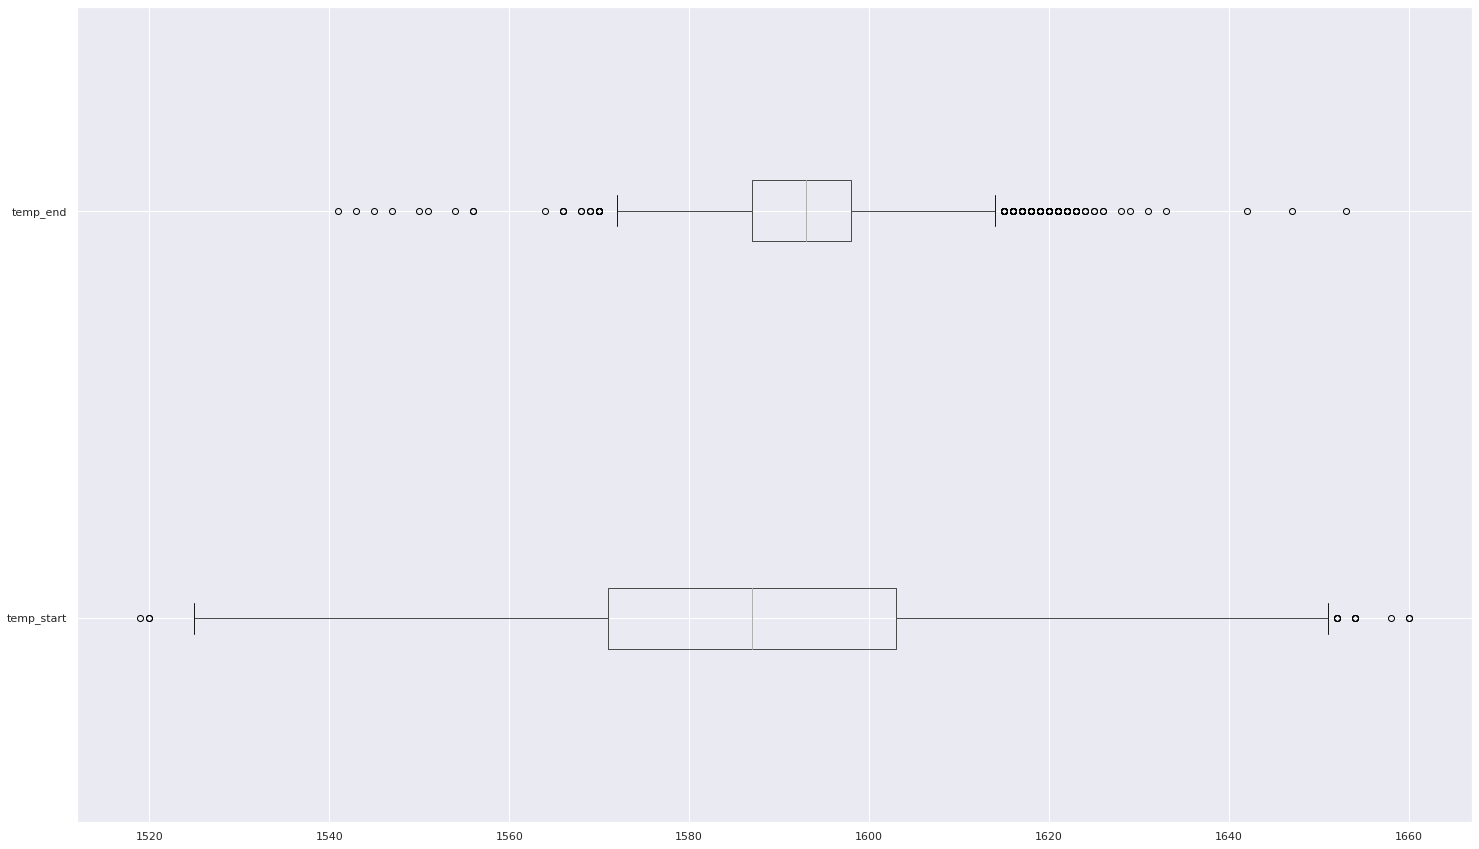

In [48]:
#диаграммы размаха начальной и конечной температур
total_data.boxplot(column = ['temp_start', 'temp_end'], vert=False)

<AxesSubplot:>

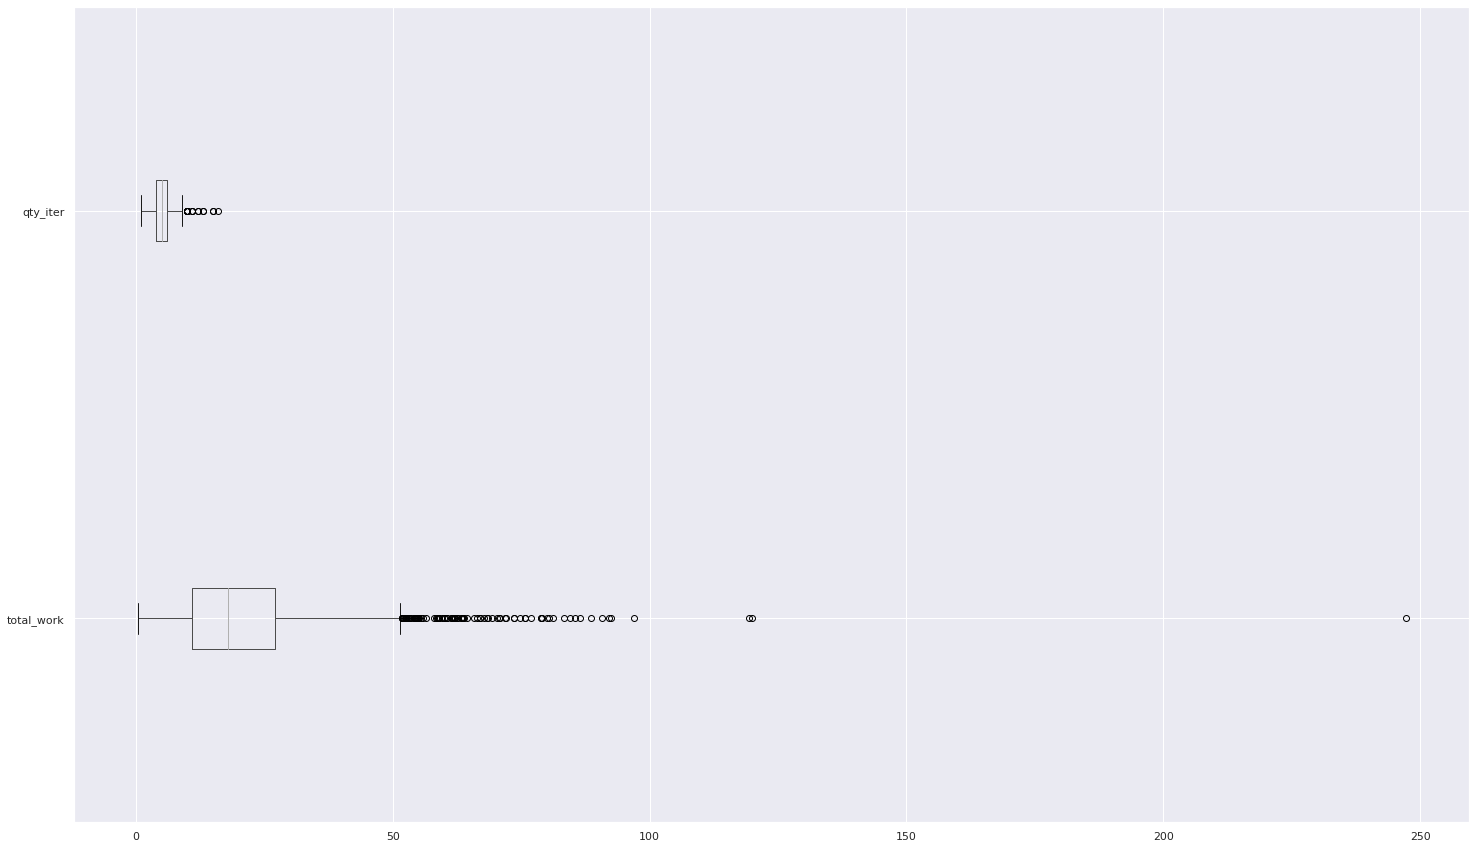

In [49]:
#диаграммы размаха количества процедур нагрева и суммарной работы
total_data.boxplot(column = ['total_work', 'qty_iter'], vert=False)

<AxesSubplot:>

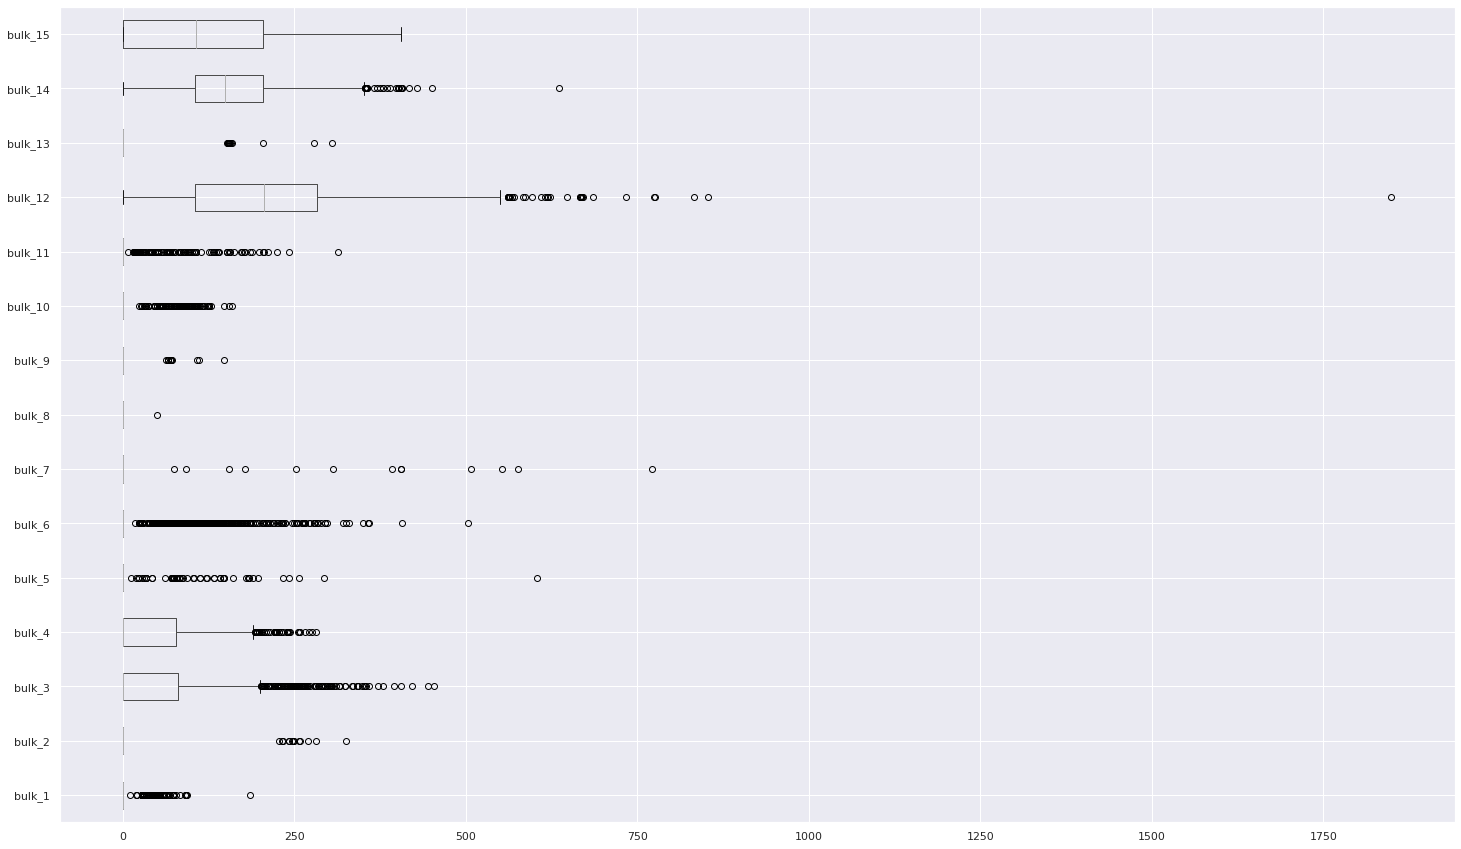

In [50]:
#диаграммы размаха подачи сыпучих материалов
total_data.boxplot(column = ['bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6',
                             'bulk_7','bulk_8','bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14',
                             'bulk_15'], vert=False
                  )

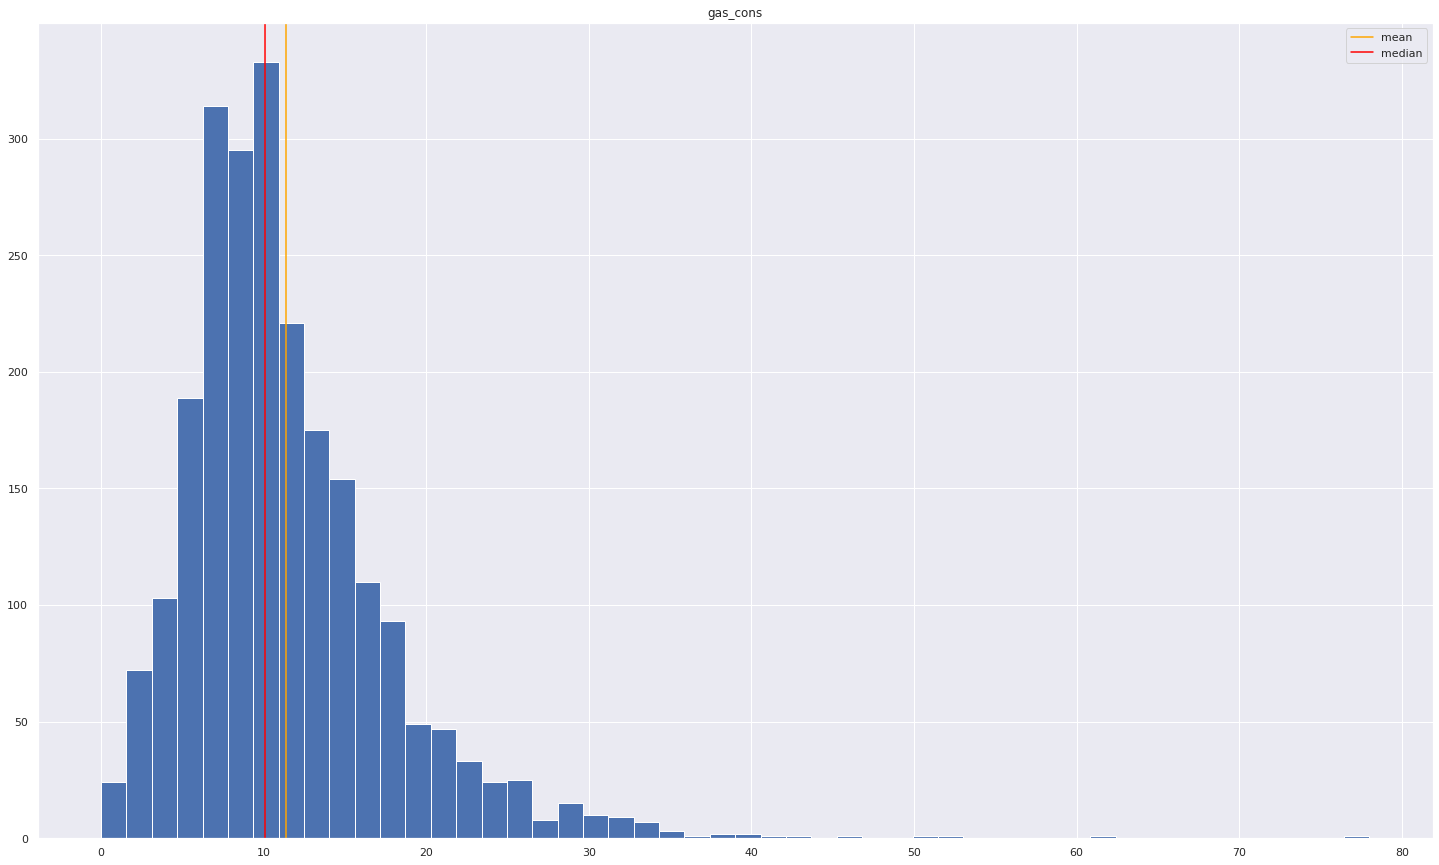

In [51]:
#гистограмма расхода газа
total_data.hist(column = ['gas_cons'], bins=50)
plt.axvline(total_data['gas_cons'].mean(), color='orange', label='mean')
plt.axvline(total_data['gas_cons'].median(), color='red', label='median')
plt.legend()

<AxesSubplot:>

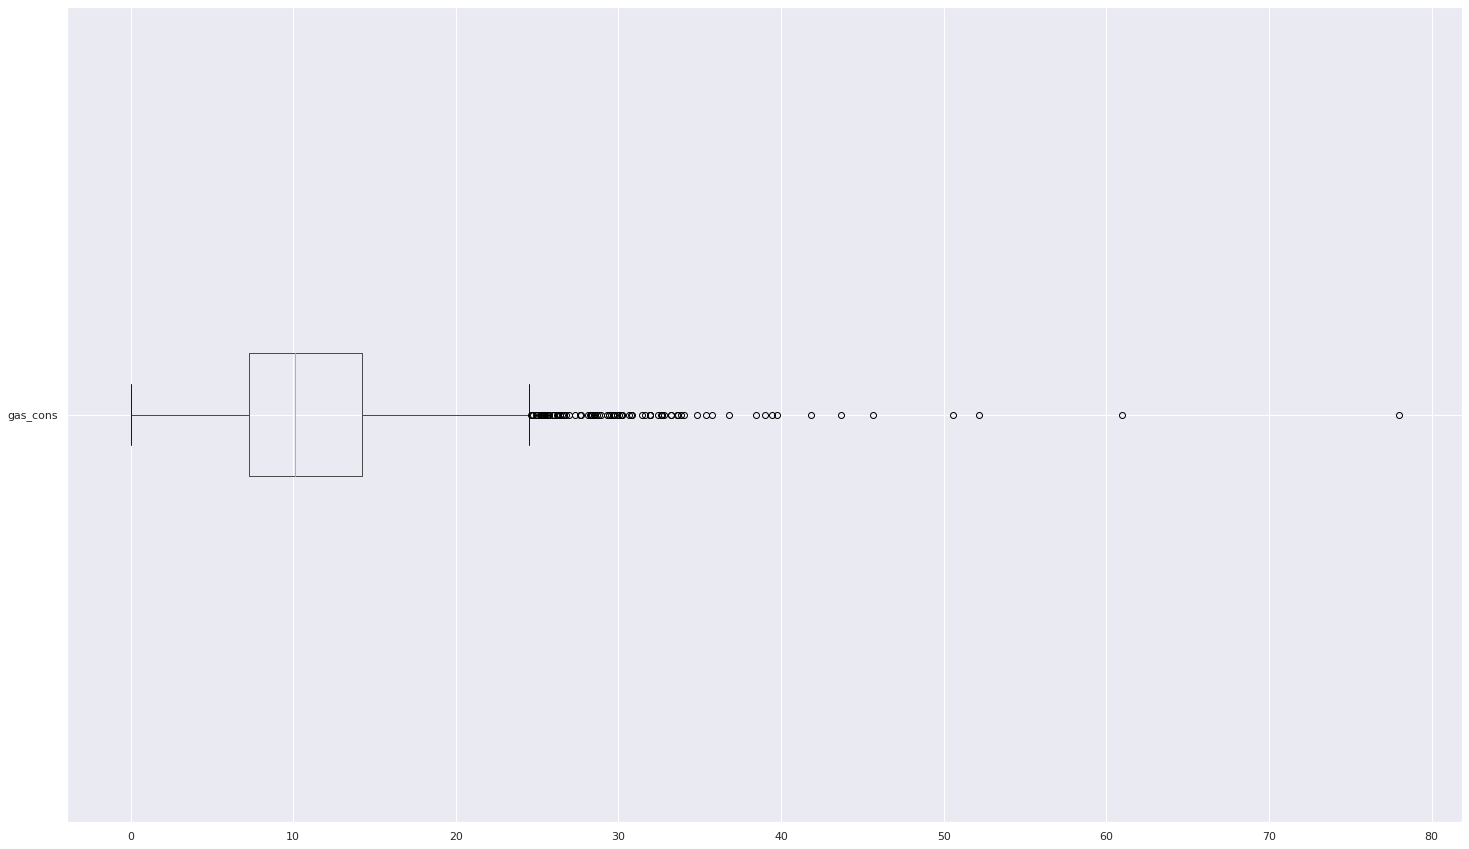

In [52]:
#диаграмма размаха расхода газа
total_data.boxplot(column = ['gas_cons'], vert=False)

график расхода газа похож на первоначальный до объединения датасетов и имеет длинный правый хвост

**Выводы по переработке данных**
1. Данные в датасетах очищенны от экстремально больших значений и от осутствующих значений.
2. Добавлены значения средняя работа и количество нагревов партии в таблицу arc. Добавлены значения начальной и конечной температуры партии в таблицу temp. Из таблицы temp удалены партии имеющие только 1 параметр температуры.
3. Данные в таблицах arc и temp агрегированы по номеру партии.
4. Данные таблиц о параметрах производственного процесса объединены в один датасет для дальнейшей передачи его моделям машинного обучения. Графики данных о параметрах производственного процесса имеют форму схожую с графиками нормального распределения с длинными правыми хвостами, кроме данных о средней работе крутой левый край и пологий относительно левого края правый край. Распределение затрат газа так же осталось с нормальным распределением с длинным правым хвостом.
5. Мультиколлениарности (большого количества парного совпадения корреляции разных признаков) в признаках не прослеживается.
6. Предлагается удалить столбцы wire_5 и bulk_8 как содержащие малый объем данных и не оказавающих значительного влияния на целевой признак.

### Обучение моделей и получение их лучших параметров

In [53]:
# разделим данные на обучающие и тестовые, закодируем признаки для линеной регрессии через обработку StandardScaler
train, test = train_test_split(total_data, test_size=0.25, random_state=190922)

train_features = train.drop(['key', 'temp_end', 'wire_5','bulk_8'], axis=1)
train_target = train[['temp_end']]

train_features_rf = train_features.copy()

test_features = test.drop (['key', 'temp_end', 'wire_5','bulk_8'], axis=1)
test_target = test[['temp_end']]
test_features_rf = test_features.copy()

scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)


cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=190922)

In [54]:
train_features_rf

,temp_start,total_work,qty_iter,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas_cons
835,1594.0,18.653419,5,0.0,0.0,53.0,0.0,0.0,0.0,0.0,...,0.0,101.134796,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,20.729915
702,1639.0,6.928672,5,0.0,0.0,0.0,53.0,0.0,0.0,0.0,...,102.0,79.045196,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,7.749842
94,1645.0,26.349852,4,0.0,228.0,0.0,0.0,72.0,0.0,0.0,...,0.0,7.556640,0.000000,96.047951,24.148801,60.094322,0.0,0.0,0.0,25.377930
516,1595.0,16.783289,5,0.0,0.0,0.0,228.0,0.0,0.0,0.0,...,203.0,140.166000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,20.104933
1230,1561.0,27.348514,4,0.0,0.0,128.0,0.0,0.0,0.0,0.0,...,217.0,147.092392,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,7.192072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210,1553.0,71.807302,9,0.0,0.0,0.0,0.0,0.0,54.0,0.0,...,102.0,45.339840,72.142723,0.000000,0.000000,0.000000,0.0,0.0,0.0,26.408812
1937,1572.0,20.471577,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,204.0,13.060320,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,9.328975
1513,1566.0,20.252596,4,0.0,0.0,103.0,0.0,0.0,0.0,0.0,...,0.0,125.143204,75.068245,0.000000,0.000000,0.000000,0.0,0.0,0.0,7.901747
1762,1578.0,29.860801,6,27.0,0.0,102.0,117.0,0.0,0.0,0.0,...,202.0,170.117996,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,15.580119


#### Случайный лес

In [55]:
# обучим и подберем параметры для модели случайного леса
model_rf = RandomForestRegressor(random_state=190922)
param_set = {
 'n_estimators':[90, 100, 150],
 'max_depth': [30, 40, 50],
 'min_samples_split':[3, 4, 5]
}

model_rf = GridSearchCV(model_rf, param_grid = param_set, cv=cv, scoring = 'neg_mean_absolute_error')
model_rf.fit(train_features_rf, train_target)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=190922),
             estimator=RandomForestRegressor(random_state=190922),
             param_grid={'max_depth': [30, 40, 50],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [90, 100, 150]},
             scoring='neg_mean_absolute_error')

In [56]:
#обучим на подобранных параметрах случайного леса модель и расcчитаем метрику mae
max_depth = model_rf.best_params_['max_depth']
min_samples_split = model_rf.best_params_['min_samples_split']
n_estimators = model_rf.best_params_['n_estimators']
model_rf_1 = RandomForestRegressor(max_depth=max_depth, min_samples_split=min_samples_split, 
                                 n_estimators=n_estimators, random_state=190922)
model_rf_1.fit(train_features_rf, train_target)

RandomForestRegressor(max_depth=40, min_samples_split=4, n_estimators=150,
                      random_state=190922)

In [57]:
model_rf.best_score_

-6.2821339311492785

#### Линейные модели

In [58]:
#обучим модель линейной регрессии и расcчитаем метрику mae
model_lr = LinearRegression()
model_lr.fit(train_features, train_target)

LinearRegression()

In [59]:
cv_result = cross_validate(model_lr, train_features_rf, train_target, scoring = 'neg_mean_absolute_error', cv=cv)

In [60]:
cv_result['test_score'].mean()

-6.587785078255858

In [61]:
# обучим модель эластичной сети и расcчитаем метрику mae
model_lr_1 = ElasticNetCV(random_state=190922, cv=cv)
model_lr_1.fit(train_features, train_target)

ElasticNetCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=190922),
             random_state=190922)

In [62]:
prediction_lr_1 = model_lr_1.predict(train_features)
print(mean_absolute_error(prediction_lr_1, train_target))

6.354114004645157


#### Градиентный бустинг

In [63]:
#обучим модель градиентного бустинга с фиксированными параметрами и расcчитаем метрику mae
model_LGBM_1 = lgbm.LGBMRegressor(n_estimators=150, max_depth=5, boosting_type = 'gbdt', 
                                  random_state=190922, learning_rate=0.05, objective='mean_absolute_error')
model_LGBM_1.fit(train_features, train_target)

LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=150,
              objective='mean_absolute_error', random_state=190922)

In [64]:
#обучим и подберем параметры для модели градиентного бустинга и расcчитаем метрику mae

score = make_scorer(mean_absolute_error, greater_is_better=True)

param_set = {
 'n_estimators':[90, 100, 150],
 'max_depth':[3, 5, 10],
 'learning_rate':[0.05, 0.1, 0.2]
}

model_LGBM = lgbm.LGBMRegressor
model_LGBM = GridSearchCV(estimator = lgbm.LGBMRegressor(boosting_type = 'gbdt', random_state = 190922, 
                                                        objective='mean_absolute_error'), cv=cv, scoring = score, 
                                                         param_grid = param_set)

model_LGBM.fit(train_features, train_target)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=190922),
             estimator=LGBMRegressor(objective='mean_absolute_error',
                                     random_state=190922),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [90, 100, 150]},
             scoring=make_scorer(mean_absolute_error))

In [65]:
score = make_scorer(mean_absolute_error, greater_is_better=True)
cv_result = cross_validate(model_LGBM_1, train_features, train_target, scoring=score, cv=cv)

In [66]:
cv_result['test_score'].mean()

6.194360704583533

In [67]:
model_LGBM.best_params_

{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150}

In [68]:
model_LGBM.best_score_

6.397800349511992

Из использованных моделей выберем LGBM c фиксированными параметрами, как показавшую наименьшую метрику mae на обучающих данных.

#### Тестирование модели

In [69]:
# расчет mae на тестовой выборке моделью LGBM (фиксированные параметры)
predict_lgbm_1 = model_LGBM_1.predict(test_features)
print(mean_absolute_error(predict_lgbm_1, test_target))

6.069410928537846


In [70]:
# расчет mae на тестовой выборке моделью LGBM (подбор параметров)
predict_lgbm = model_LGBM.predict(test_features)
print(mean_absolute_error(predict_lgbm, test_target))

6.224250990505834


In [71]:
train_features = pd.DataFrame(data=train_features, columns=train_features_rf.columns)
test_features = pd.DataFrame(data=test_features, columns=test_features_rf.columns)

In [72]:
#получим оценку mae случайного регрессора
dr = DummyRegressor()
dr.fit(train_features, train_target)

predict_dm = dr.predict(test_features)
print(mean_absolute_error(predict_dm, test_target))

8.406533349894426


In [73]:
# функция для построения графика значимости признаков
def chart_feature_imp(model, model_type):
    if model_type=='gb' or model_type=='rf':
        feature_imp = pd.Series(model.feature_importances_, index=test_features.columns).sort_values(ascending=False)

        ax = sns.barplot(x=feature_imp, y=feature_imp.index)
        _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
        _ = ax.set_title('Визуализация важности признаков')
    if model_type=='lr':
        feature_imp = pd.Series(model.coef_, index=test_features.columns).sort_values(ascending=False)

        ax = sns.barplot(x=feature_imp, y=feature_imp.index)
        _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
        _ = ax.set_title('Визуализация важности признаков')

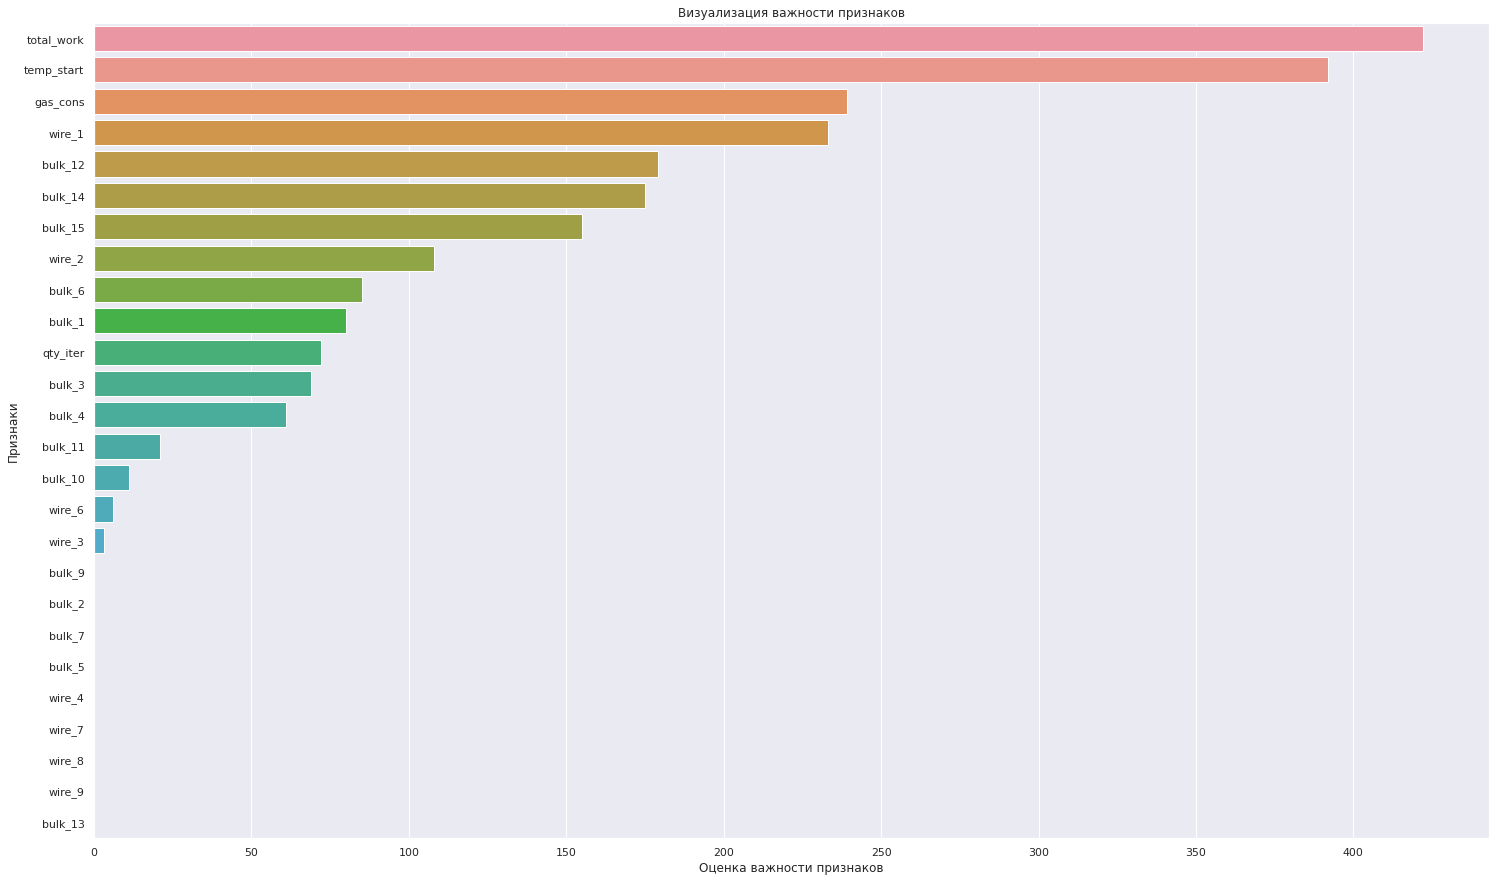

In [74]:
#посторение графика значимости признаков
chart_feature_imp(model = model_LGBM_1, model_type='gb')

модель градиентного бустинга (LGBM) показала на тестовых данных метрику mae равную 6.07 градусов

**Выводы по переработке и обучению моделей**
1. Первоначальные данные переработаны для дальнейшего использования в моделях машинного обучения (удалены или заменены значением 0 отсутствующие данные, данные агрегированы и соединены в единую таблицу по номеру партии), разделены на обучающую и тестовую выборки, признаки обработаны процедурой StandardScaler (кроме признаков для случайного леса)
2. Использованы модели случайного леса (с подбором гиперпараметров), линейной регрессии (гиперпараметры по умолчанию), эластичной сети (гиперпараметры по умолчанию), LGBM (гиперпараметры: количество деревьев 150, обучающая выборка 0,05, тип бустинга - gbdt, максимальная глубина дерева 5), LGBM (с подбором гиперпараметров). Лучшие метрики mae показала модель градиентного бустинга(гиперпараметры: количество деревьев 150, обучающая выборка 0,05, тип бустинга - gbdt, максимальная глубина дерева 5) - 6.19 градусов на обучающих данных и 6.07 градусов на тестовых данных. Предлагается использовать ее для предсказания конечной температуры.
3. Показатель метрики mae случайного регрессора (DummyRegressor) -  8.40 градусов, что больше показателя метрики mae лучшей модели.

### Очет

учитывая вышеприведеннй график важности признаков для выбранной модели исключим некоторые признаки их обучающих признаков

In [75]:
#получим тренировочные и тестовые признаки для улучшения выбраной модели 
train, test = train_test_split(total_data, test_size=0.25, random_state=190922)
train_features = train.drop(['key', 'temp_end', 'wire_5','bulk_8','bulk_9','bulk_2','bulk_7','bulk_5','bulk_13',
                            'wire_4', 'wire_7', 'wire_8', 'wire_9'], axis=1)
train_target = train[['temp_end']]
test_features = test.drop (['key', 'temp_end', 'wire_5','bulk_8','bulk_9','bulk_2','bulk_7','bulk_5','bulk_13',
                            'wire_4', 'wire_7', 'wire_8', 'wire_9'], axis=1)
test_target = test[['temp_end']]
scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)


In [76]:
#обучим модель градиентного бустинга с фиксированными параметрами
model_LGBM_1 = lgbm.LGBMRegressor(n_estimators=150, max_depth=5, boosting_type = 'gbdt', 
                                  random_state=190922, learning_rate=0.05, objective='mean_absolute_error')
model_LGBM_1.fit(train_features, train_target)

LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=150,
              objective='mean_absolute_error', random_state=190922)

In [77]:
score = make_scorer(mean_absolute_error, greater_is_better=True)
cv_result = cross_validate(model_LGBM_1, train_features, train_target, scoring=score, cv=cv)

In [78]:
cv_result['test_score'].mean()

6.194360704583533

In [79]:
# расчет mae на тестовой выборке моделью LGBM (фиксированные параметры)
predict_lgbm_1 = model_LGBM_1.predict(test_features)
print(mean_absolute_error(predict_lgbm_1, test_target))

6.069410928537846


метрика mae не изменилась после исключения части неважных для модели признаков

**Отчет о работе над проектом**
1. Все пункты плана выполнены в полном объеме. Кроме заявленного обучена и рассчитана метрика mae на модели ElasticNetCV, LGBM с фиксированными параметрами и LGMB с подбором параметров.
2. В процессе выполнения задания возникла сложность в том, что предсказания модели линейной регрессии выдавали аномально высокую метрику mae и метрики mae моделей бустинга больше метрики линейной модели. Данная проблема имела причиной неправильное указание размера обучающей выборки.
3. Признаки для обучения модели были собраны из 5 датасетов(мощность поданная на электроды, подача сыпучих материалов, подача проволочных материалов, замеры температуры плавления, данные расходе газа (данные из датасетов содержащих время подачи сыпучих и проволочных материалов в задаче не использовались) из которых были удалены пропущенные значения и данные о температуре менее 1500 град (замеры температуры плавления), аномально низкие значения были заменены средними(мощность поданная на электроды), пропуски в таблицах о сыпучих и проволочных материалах была заменена нулями. Данные в таблицах были трансформированы в суммарную мощность и количество процедур нагрева (мощность поданная на электроды), начальная и конечная температура партии (замеры температуры плавления) и агрегированы по номеру партии. После проведенных переработок графики распределения основных признаков не претерпели значительных изменнений и остались похожы на график нормального распределения.
4. В результате выбора модели по минимальной метрике mae отобрана модель градиентного бустинга из библиотеки Lightgbm. Метрика модели на обучающих данных составила 6.19 градусов на тестовых данных 6.07 градусов. Метрика mae на случайном регрессоре составляет 8.40 градусов.
5. Согласно отчета о важности признаков полученной модели для нее важны следующие признаки в порядке убывания:
- total_work(суммарная работа как произведение мощности поданной на электроды и времени нагрева)
- temp_start(начальная температура партии)
- gas_cons(затраты газа)
- wire_1
- bulk_12
- bulk_14
- bulk_15
- wire_2
- bulk_6
- bulk_1
- qty_iter (количество операций нагрева)
- bulk_3
- bulk_4
- bulk_11
- bulk_10
- wire_6
- wire_3
6. Гиперпараметры лучшей модели следующие: количество деревьев 150, обучающая выборка 0,05, тип бустинга - gbdt, максимальная глубина дерева 5, random_state 190922.